# Fire Calls San Francisco - Spark Analysis 🚒

# 1 - Obtener datos e importar herramientas

Utilizando el dataset “Fire Calls San Franciso” responder a las siguientes preguntas utilizando Spark:

1. ¿Cuáles fueron los diferentes tipos de llamadas que hubo en 2018?
2. ¿Qué mes de 2018 fue el que tuvo un número mayor de llamadas?
3. ¿Cuál vecindario de San Francisco fue el que realizó el mayor número de llamadas en 2018?
4. ¿Cuáles vecindarios tuvieron el peor tiempo de respuesta a las llamadas en 2018?
5. ¿Cuál semana del 2018 tuvo el mayor número de llamadas?
6. ¿Existe alguna correlación entre los vecindarios, códigos postales y número de llamadas?

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 46 kB/s 
     |████████████████████████████████| 199 kB 58.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=b7e6e7bb416730bd026d5cf2ae2f385df1eb31bde8ea4f1adbc59bbf76b33bcc
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession #-- importo la sesión para Spark
import pandas as pd #-- Data Frames en pandas como objeto pd
import requests #-- para bajar archivos públicos de la nube
from io import StringIO #-- manipular direcciones URL

In [3]:
#-- todo lo que sigue es el proceso para bajar de un folder público la información en CSV
#-- importante saber que la dirección tiene que ser pública si no, pum! pura riatiñe
url = 'https://drive.google.com/file/d/16uL_sLMRKuoYlUZ59N5hda4eLLJs0gs1/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?export=download&id=' + file_id
url_request = requests.get(dwn_url).text
csv_raw = StringIO(url_request)
df = pd.read_csv(csv_raw)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12,13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
#-- Es algo ilógico regresar el DataFrame a CSV pero para fines didácticos Spark lo hacemos
#-- El CSV quedará en los archivos del entorno
df.to_csv (r'FireCalls.csv', index = False, header=True)

# 2 - Arrancamos Spark ⭐

In [5]:
#--inicializamos la sesion
spark = SparkSession.builder\
  .master('local[*]')\
  .appName('hello_world_spark')\
  .getOrCreate()

#--probamos que spark se haya inicializado
spark

In [43]:
#--importamos librerías de python para definir fechas
from datetime import datetime, date
#--objeto de pyspark para modificar dataframes
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, unix_timestamp, to_date, to_timestamp
from pyspark.sql import functions as F

In [7]:
#-- Llemos con Spark el CSV recien creado para empezar el análisis
sdf = spark.read.csv('FireCalls.csv', header =True)

In [8]:
#-- leo el Spark DataFrame
sdf.show()

+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+------+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea|   Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+------+----------------+---

In [9]:
#-- Leo el CSV con Spark solo para ver que las 2 tablas son iguales
spark.read.csv('FireCalls.csv', header = True).show()

+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+------+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|       AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea|   Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+--------------------+--------------------+----+-------+---------+-----------+------+----------------+---

In [36]:
#--vemos los tipos de datos que tenemos en nuestro data frame de spark
sdf.dtypes

[('CallNumber', 'string'),
 ('UnitID', 'string'),
 ('IncidentNumber', 'string'),
 ('CallType', 'string'),
 ('CallDate', 'string'),
 ('WatchDate', 'string'),
 ('CallFinalDisposition', 'string'),
 ('AvailableDtTm', 'string'),
 ('Address', 'string'),
 ('City', 'string'),
 ('Zipcode', 'string'),
 ('Battalion', 'string'),
 ('StationArea', 'string'),
 ('Box', 'string'),
 ('OriginalPriority', 'string'),
 ('Priority', 'string'),
 ('FinalPriority', 'string'),
 ('ALSUnit', 'string'),
 ('CallTypeGroup', 'string'),
 ('NumAlarms', 'string'),
 ('UnitType', 'string'),
 ('UnitSequenceInCallDispatch', 'string'),
 ('FirePreventionDistrict', 'string'),
 ('SupervisorDistrict', 'string'),
 ('Neighborhood', 'string'),
 ('Location', 'string'),
 ('RowID', 'string'),
 ('Delay', 'string')]

In [37]:
#-- contamos el número de filas que tenemos o datos
sdf.count()

175296

In [38]:
#--- imprimimos el esquema 
sdf.printSchema()

root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- Sup

In [39]:
#-- aquí hago un nuevo dataframe porque los tiempos están en String y no en Tiempo
fuego = (sdf
 .withColumn("IncidentDate",to_date(col("CallDate"),"MM/dd/yyyy")).drop("CallDate")
 .withColumn("OnWatchDate",to_date(col("WatchDate"),"MM/dd/yyyy")).drop("WatchDate")
 .withColumn("AvailableDtTs",to_timestamp(col("AvailableDtTm"),"MM/dd/yyyy hh:mm:ss a")).drop("AvailableDtTm")
)

fuego.printSchema()

root
 |-- CallNumber: string (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: string (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPriority: string (nullable = true)
 |-- ALSUnit: string (nullable = true)
 |-- CallTypeGroup: string (nullable = true)
 |-- NumAlarms: string (nullable = true)
 |-- UnitType: string (nullable = true)
 |-- UnitSequenceInCallDispatch: string (nullable = true)
 |-- FirePreventionDistrict: string (nullable = true)
 |-- SupervisorDistrict: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Location: string (nullable = true)


# 3 - Responder Preguntas 1 a 1 ✍

¿Cuáles fueron los diferentes tipos de llamadas que hubo en 2018?

In [133]:
fuego.filter(year("IncidentDate")==2018).groupBy("CallType") \
.count().orderBy("count",ascending=False).show()

+--------------------+-----+
|            CallType|count|
+--------------------+-----+
|    Medical Incident| 7004|
|              Alarms| 1144|
|      Structure Fire|  906|
|   Traffic Collision|  433|
|        Outside Fire|  153|
|               Other|  114|
|Citizen Assist / ...|  113|
|Gas Leak (Natural...|   69|
|        Water Rescue|   43|
|Elevator / Escala...|   36|
|   Electrical Hazard|   30|
|        Vehicle Fire|   28|
|Smoke Investigati...|   28|
|          Fuel Spill|   10|
|Odor (Strange / U...|   10|
|              HazMat|    5|
|Train / Rail Inci...|    5|
|  Suspicious Package|    3|
|       Assist Police|    1|
|           Explosion|    1|
+--------------------+-----+



¿Qué mes de 2018 fue el que tuvo un número mayor de llamadas?

In [134]:
fuego.filter(year("IncidentDate")==2018) \
.groupBy(month("IncidentDate")).count() \
.orderBy("count",ascending=False).show()

+-------------------+-----+
|month(IncidentDate)|count|
+-------------------+-----+
|                 10| 1068|
|                  5| 1047|
|                  3| 1029|
|                  8| 1021|
|                  1| 1007|
|                  7|  974|
|                  6|  974|
|                  9|  951|
|                  4|  947|
|                  2|  919|
|                 11|  199|
+-------------------+-----+



¿Cuál vecindario de San Francisco fue el que realizó el mayor número de llamadas en 2018?

In [135]:
fuego.filter(year("IncidentDate")==2018) \
.groupBy("Neighborhood").count() \
.orderBy("count",ascending=False).show()

+--------------------+-----+
|        Neighborhood|count|
+--------------------+-----+
|          Tenderloin| 1393|
|     South of Market| 1053|
|             Mission|  913|
|Financial Distric...|  772|
|Bayview Hunters P...|  522|
|    Western Addition|  352|
|     Sunset/Parkside|  346|
|            Nob Hill|  295|
|        Hayes Valley|  291|
|      Outer Richmond|  262|
| Castro/Upper Market|  251|
|         North Beach|  231|
|           Excelsior|  212|
|        Potrero Hill|  210|
|  West of Twin Peaks|  210|
|     Pacific Heights|  191|
|              Marina|  191|
|           Chinatown|  191|
|         Mission Bay|  178|
|      Bernal Heights|  170|
+--------------------+-----+
only showing top 20 rows



Cuáles vecindarios tuvieron el peor tiempo de respuesta a las llamadas en 2018?

In [137]:
fuego.select("Neighborhood","Delay") \
.filter(year("IncidentDate") == 2018) \
.orderBy("Delay",ascending=False).show()

+--------------------+---------+
|        Neighborhood|    Delay|
+--------------------+---------+
|     South of Market| 94.71667|
|Bayview Hunters P...|92.816666|
|     South of Market|91.666664|
|      Inner Richmond|90.433334|
|        Russian Hill| 9.983334|
|             Mission|     9.95|
|    Golden Gate Park| 9.933333|
|     South of Market| 9.933333|
|        Potrero Hill| 9.916667|
|           Chinatown|      9.9|
|             Portola| 9.866667|
|         Mission Bay|     9.85|
|        Inner Sunset| 9.816667|
|Financial Distric...|      9.8|
|      Bernal Heights| 9.783334|
|      Bernal Heights| 9.766666|
| Castro/Upper Market| 9.733334|
|             Portola| 9.683333|
|     South of Market| 9.666667|
|Bayview Hunters P...| 9.666667|
+--------------------+---------+
only showing top 20 rows



In [62]:
fuego.select(min("Delay"),mean("Delay"),max("Delay")).show()

+-----------+------------------+----------+
| min(Delay)|        avg(Delay)|max(Delay)|
+-----------+------------------+----------+
|0.016666668|3.8923641541750356|      99.9|
+-----------+------------------+----------+



¿Cuál semana del 2018 tuvo el mayor número de llamadas?

In [63]:
fuego.filter(year("IncidentDate")==2018)
.groupBy(weekofyear("IncidentDate")).count()
.orderBy("count",ascending=False).show(10,False)

+------------------------+-----+
|weekofyear(IncidentDate)|count|
+------------------------+-----+
|22                      |259  |
|40                      |255  |
|43                      |250  |
|25                      |249  |
|1                       |246  |
|44                      |244  |
|32                      |243  |
|13                      |243  |
|11                      |240  |
|18                      |236  |
+------------------------+-----+
only showing top 10 rows



¿Existe alguna correlación entre los vecindarios, códigos postales y número de llamadas?

In [69]:
#-- Hay evidencia que en un zip code hay varios neighborhoods
fuego.select("ZipCode").distinct().count()

28

In [70]:
#-- Hay evidencia que en un neighborhood hay varios zips (OH GOd!)
fuego.select("Neighborhood").distinct().count()

42

In [138]:
#--Empezamos con una agrupación y creamos una tablita sencilla para exportarlo a PANDITAS
a = fuego.groupby("ZipCode").agg(countDistinct('Neighborhood'),count('IncidentNumber')) \
.orderBy(count('IncidentNumber'),ascending=False)
a.show(28,False)

+-------+-------------------+---------------------+
|ZipCode|count(Neighborhood)|count(IncidentNumber)|
+-------+-------------------+---------------------+
|94102.0|6                  |21840                |
|94103.0|8                  |20897                |
|94110.0|6                  |14801                |
|94109.0|7                  |14686                |
|94124.0|5                  |9236                 |
|94112.0|6                  |8421                 |
|94115.0|6                  |7812                 |
|94107.0|5                  |6941                 |
|94122.0|6                  |6355                 |
|94133.0|4                  |6246                 |
|94117.0|7                  |5804                 |
|94114.0|7                  |5175                 |
|94118.0|7                  |5157                 |
|94134.0|6                  |5009                 |
|94121.0|4                  |4555                 |
|94132.0|4                  |4321                 |
|94105.0|2  

In [95]:
#--Empezamos con una agrupación y creamos una tablita sencilla para exportarlo a PANDITAS
b = fuego.groupby("Neighborhood").agg(countDistinct('ZipCode'),count('IncidentNumber')).orderBy(count('IncidentNumber'),ascending=False)
b.show(42,False)

+------------------------------+--------------+---------------------+
|Neighborhood                  |count(ZipCode)|count(IncidentNumber)|
+------------------------------+--------------+---------------------+
|Tenderloin                    |3             |22785                |
|South of Market               |4             |16623                |
|Mission                       |3             |15912                |
|Financial District/South Beach|7             |11912                |
|Bayview Hunters Point         |3             |9616                 |
|Sunset/Parkside               |3             |6984                 |
|Western Addition              |4             |6591                 |
|Nob Hill                      |4             |5810                 |
|Outer Richmond                |3             |4604                 |
|Hayes Valley                  |4             |4357                 |
|Castro/Upper Market           |5             |4176                 |
|West of Twin Peaks 

# 4 - Agamos Grafiquiñes en Seaborn 📈

In [97]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
panda_a = a.toPandas()
panda_b = b.toPandas()

In [108]:
panda_a.rename(columns = {'ZipCode':'Postal', 'count(Neighborhood)':'Vecindario',
                              'count(IncidentNumber)':'Llamadas'}, inplace = True)
panda_b.rename(columns = {'Neighborhood':'Vecindario', 'count(ZipCode)':'Postal',
                              'count(IncidentNumber)':'Llamadas'}, inplace = True)

In [128]:
#-- Como los identificadores de código postal y de vecindarios son enormes, los enuemro a ambos
panda_a["Postal_Mas_a_Menos"] = [i for i in range(1,28+1)]
panda_b["Vecindario_Mas_a_Menos"] = [i for i in range(1,42+1)]

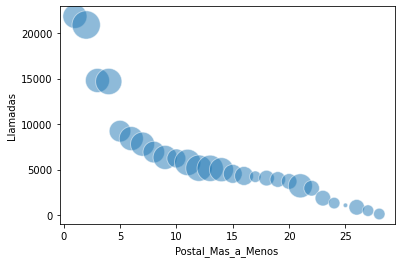

In [129]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=panda_a, x='Postal_Mas_a_Menos', y="Llamadas", size="Vecindario", legend=False, alpha=0.5, sizes=(20, 800))

# show the graph
plt.show()

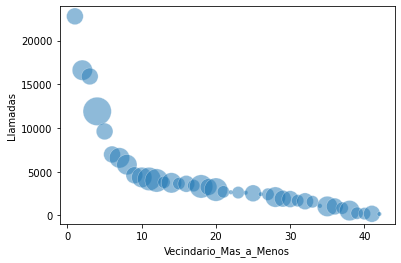

In [131]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=panda_b, x='Vecindario_Mas_a_Menos', y="Llamadas", size="Postal", legend=False, alpha=0.5, sizes=(20, 800))

# show the graph
plt.show()

# 5-Después de analizaar detenemos Spark 💀

In [139]:
#-- Detener la sesión "esto es importante"
spark.stop()